In [1]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
import re

## Load Files

In [2]:
# Read all columns and concatenate them into a single dataframe
df = pd.read_csv("join_df.csv", header = 0, sep="\t", index_col=0)

In [3]:
df.columns

Index(['Year Published', 'JIF', 'ISSN', 'Journal name', 'Eigenfactor',
       'Authors', 'Author Full Name', 'Document Title', 'Publication Name',
       'Author Keywords', 'Keywords Plus®', 'Abstract', 'Author Address',
       'Reprint Address', 'E-mail Address', 'ResearcherID Number', 'ORCIDs',
       'Funding Agency and Grant Number', 'Cited Reference Count',
       'Times cited', 'Usage Count (Last 180 Days)',
       'Usage Count (Since 2013)', 'Publisher', 'Publisher City',
       'Publisher Address', 'ISO Source Abbreviation', 'Publication Date',
       'Volume', 'Issue', 'Beginning Page', 'Ending Page',
       'Digital Object Identifier (DOI)', 'Page Count',
       'Web of Science Categories', 'eISSN'],
      dtype='object')

In [4]:
df.describe()

,Year Published,JIF,Eigenfactor,Cited Reference Count,Times cited,Usage Count (Last 180 Days),Usage Count (Since 2013),Page Count
count,4599.000000,4599.000000,1708.000000,4599.000000,4599.000000,4599.000000,4599.000000,4599.000000
mean,2010.736682,4.175706,0.061004,39.363775,34.216134,0.422266,9.274407,9.462274
std,6.779574,2.655590,0.118123,17.914679,51.651986,1.172020,13.197761,3.590294
min,2000.000000,0.193000,0.001000,0.000000,0.000000,0.000000,0.000000,2.000000
25%,2005.000000,2.531000,0.014000,27.000000,9.000000,0.000000,3.000000,7.000000
50%,2011.000000,3.694000,0.033000,37.000000,19.000000,0.000000,6.000000,9.000000
75%,2017.000000,5.204000,0.060000,48.000000,39.000000,0.000000,12.000000,11.000000
max,2022.000000,87.244000,1.540000,273.000000,833.000000,26.000000,271.000000,38.000000


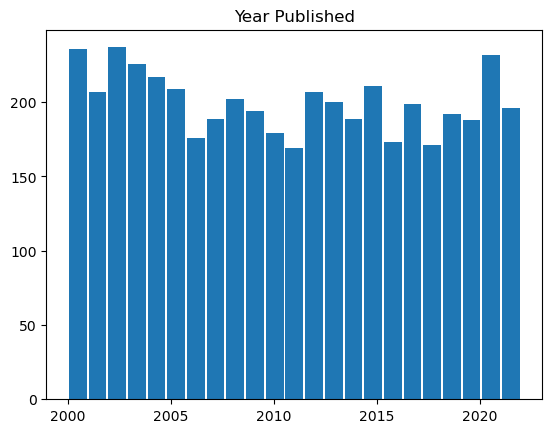

In [5]:
features = ['Year Published', 'JIF', 'Page Count', 'Times cited']
fig, ax = plt.subplots()
ax.hist(df[features[0]], bins=23, rwidth=0.9)
ax.set_title(features[0])
plt.show()

fig.savefig('year_hist.png', dpi=100)

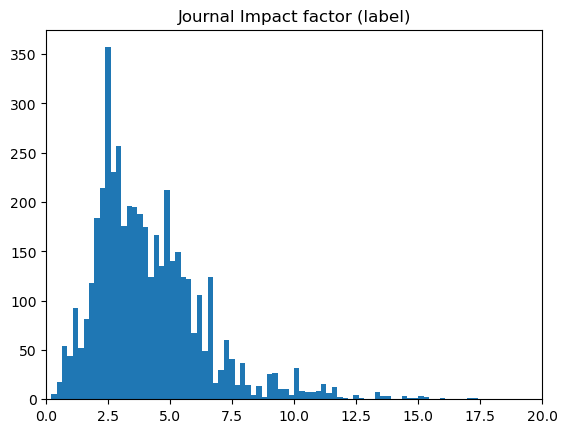

In [6]:
features = ['Year Published', 'JIF', 'Page Count', 'Times cited']
fig, ax = plt.subplots()
ax.hist(df[features[1]], bins=400)
ax.set_title('Journal Impact factor (label)')
ax.set_xlim(0,20)
plt.show()
fig.savefig('JIF_hist.png', dpi=100)

In [7]:
df.groupby('Web of Science Categories').count()['JIF'].sort_values(ascending=False).head(10)

Web of Science Categories
Radiology, Nuclear Medicine & Medical Imaging                                 841
Pharmacology & Pharmacy                                                       760
Neurosciences                                                                 310
Chemistry, Medicinal                                                          292
Biochemistry & Molecular Biology; Chemistry, Medicinal; Chemistry, Organic    147
Biochemistry & Molecular Biology                                              138
Multidisciplinary Sciences                                                    138
Chemistry, Medicinal; Chemistry, Organic                                      125
Biochemistry & Molecular Biology; Neurosciences                               120
Biochemical Research Methods; Chemistry, Medicinal; Chemistry, Analytical     100
Name: JIF, dtype: int64

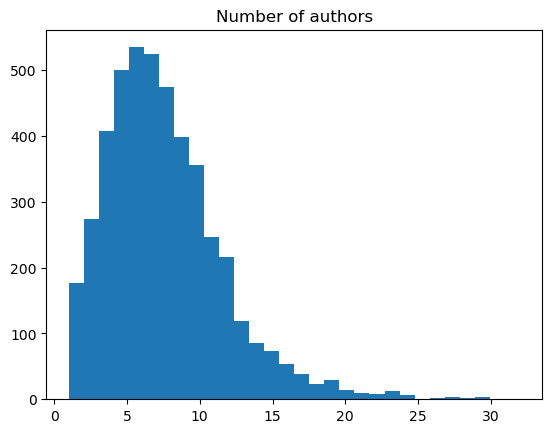

In [8]:
df['num_auth'] = df['Authors'].apply(lambda x: len(x.split(';')))
fig, ax = plt.subplots()
ax.hist(df['num_auth'], bins=30)
ax.set_title('Number of authors')
#ax.set_xlim(0,20)
plt.show()
fig.savefig('Auth_hist.png', dpi=100)

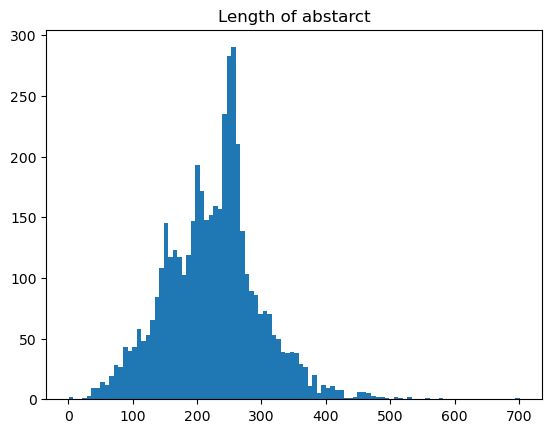

In [9]:
df['num_words'] = df['Abstract'].apply(lambda x: len(x.split(' ')))
fig, ax = plt.subplots()
ax.hist(df['num_words'], bins=100)
ax.set_title('Length of abstarct')
#ax.set_xlim(0,20)
plt.show()
fig.savefig('Abs_hist.png', dpi=100)

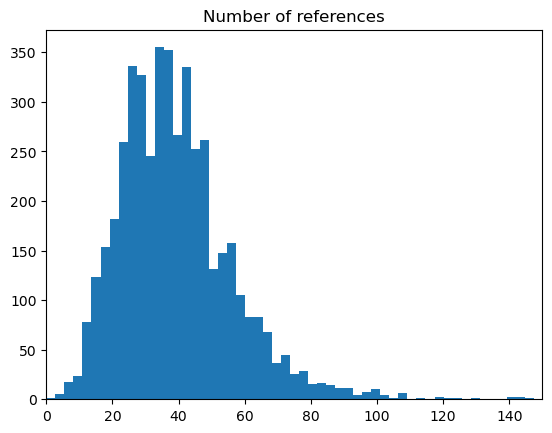

In [10]:
fig, ax = plt.subplots()
ax.hist(df['Cited Reference Count'], bins=100)
ax.set_title('Number of references')
ax.set_xlim(0,150)
plt.show()
fig.savefig('Ref_hist.png', dpi=100)

C:\Users\Artem\AppData\Local\Temp\ipykernel_27164\1711940875.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)


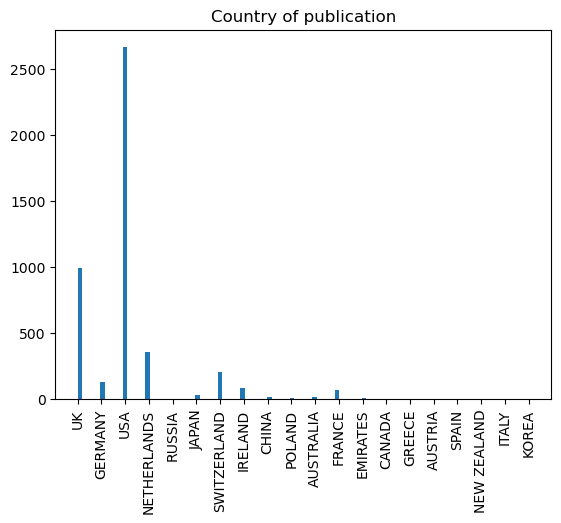

In [11]:
df['Pub_country'] = df['Publisher Address'].apply(lambda x: x.split(',')[-1].split(' ')[-1])
df['Pub_country'] = df['Pub_country'].apply(lambda x: 'USA' if 'usa' in x.lower() else x)
df['Pub_country'] = df['Pub_country'].apply(lambda x: 'USA' if 'states' in x.lower() else x)
df['Pub_country'] = df['Pub_country'].apply(lambda x: 'UK' if 'ngland' in x.lower() else x)
df['Pub_country'] = df['Pub_country'].apply(lambda x: 'UK' if 'scotland' in x.lower() else x)
df['Pub_country'] = df['Pub_country'].apply(lambda x: 'NEW ZEALAND' if 'zealand' in x.lower() else x)
fig, ax = plt.subplots()
ax.hist(df['Pub_country'], bins=100)
ax.set_title('Country of publication')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)

plt.show()
fig.savefig('Pub_country.png', dpi=100)

In [12]:
def remove_authors(input_string):
    pattern = re.compile(r'\[.*?\]')
    result_string = re.sub(pattern, '  ', input_string)
    country_set = {address.split(',')[-1].strip() for address in result_string.split(';')}
    country_set_clean = set()
    for contry in country_set:
       if 'usa' in contry.lower(): country_set_clean.add('USA')
       elif 'states' in contry.lower(): country_set_clean.add('USA')
       elif 'england' in contry.lower(): country_set_clean.add('UK')
       elif 'scotland' in contry.lower(): country_set_clean.add('UK')
       else: country_set_clean.add(contry)
    return country_set_clean

C:\Users\Artem\AppData\Local\Temp\ipykernel_27164\304904566.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)


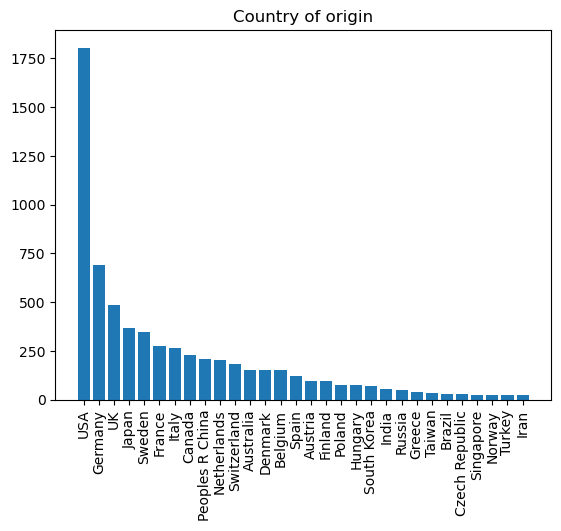

In [14]:

Auth_country_ser = df['Author Address'].astype(str).apply(lambda x: remove_authors(x)).explode()
to_plot = Auth_country_ser.groupby(Auth_country_ser).size().sort_values(ascending=False)
to_plot = to_plot[to_plot.values > 20]
fig, ax = plt.subplots()
ax.bar(x = to_plot.index, height = to_plot.values)
ax.set_title('Country of origin')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)

plt.show()
fig.savefig('Auth_country.png', dpi=100)